# Assignment 6
Halka Hanna


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ARIMA
from utilsforecast.losses import rmse, mae, smape
from statsforecast.models import AutoETS
from statsforecast.arima import ARIMASummary
from statsmodels.stats.diagnostic import acorr_ljungbox
from fpppy.utils import plot_series

import warnings
warnings.filterwarnings('ignore')

In [13]:
def plot_base(col, title, xlabel, ylabel):
    plt.figure(figsize=(12, 3))
    plt.plot(col, color='#F3D407')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

---
## Daily Temperature

In [14]:
tempt = pd.read_csv('../data/daily_tempt.csv')
tempt['data_ind'] = tempt['Date']
tempt = tempt.set_index('data_ind')
tempt.index = pd.to_datetime(tempt.index)

### 1 Stationarity and Differencing

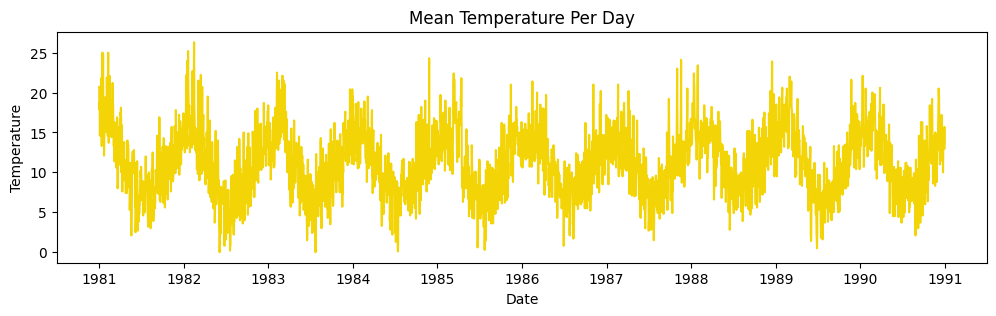

In [15]:
plot_base(tempt['mean-tempt'], 'Mean Temperature Per Day', 'Date', 'Temperature')

In [16]:
result = adfuller(tempt['mean-tempt'])
print(f'p-value = {result[1]:.5f}')

p-value = 0.00025


In this graphic we have static variance, our p-value = 0.00025 so our series is stationary.
So we don't need any transformation.

In [17]:
y_seasonal = tempt['mean-tempt'].diff(365).dropna()
result = adfuller(y_seasonal)
print(f"ADF seasonal diff p-value = {result[1]:.5f}")

y_seasonal_first = y_seasonal.diff().dropna()
result = adfuller(y_seasonal_first)
print(f"ADF seasonal+first diff p-value = {result[1]:.5f}")

ADF seasonal diff p-value = 0.00000
ADF seasonal+first diff p-value = 0.00000


### 2 Manual Model Selection

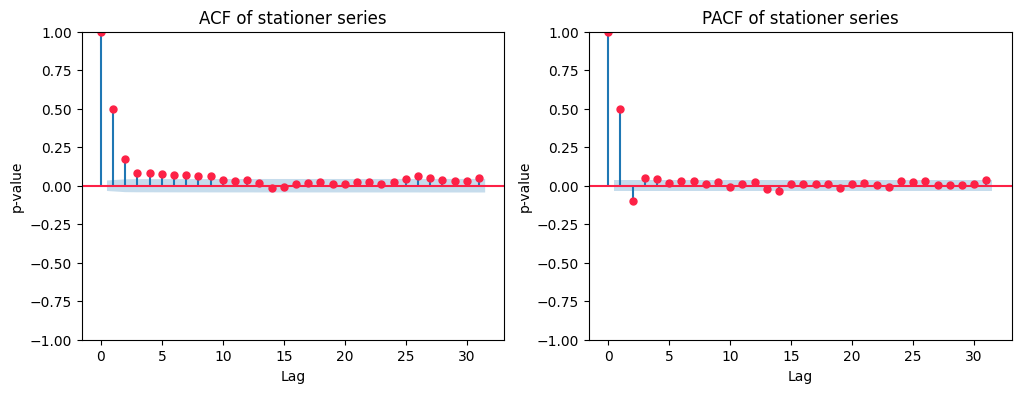

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(y_seasonal, lags=31, ax=axes[0], color='#FD2146')
axes[0].set_title('ACF of stationer series')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('p-value')

plot_pacf(y_seasonal, lags=31, ax=axes[1], color='#FD2146')
axes[1].set_title('PACF of stationer series')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p-value')

plt.show()

### 3 Estimation and AutoARIMA

In [51]:
train_df = tempt.loc[tempt.index < '1988-01-01']
val_df = tempt.loc[tempt.index >= '1988-01-01']

In [52]:
train = train_df[['mean-tempt']].reset_index()
train['unique_id'] = 'tempt'
train.rename(columns={'data_ind': 'ds', 'mean-tempt': 'y'}, inplace=True)
train = train[['unique_id', 'ds', 'y']]

val = val_df[['mean-tempt']].reset_index()
val['unique_id'] = 'tempt'
val.rename(columns={'data_ind': 'ds', 'mean-tempt': 'y'}, inplace=True)
val = val[['unique_id', 'ds', 'y']]

In [54]:
models = [
  ARIMA(order=(0, 1, 1), seasonal_order=(2, 2, 2), season_length=31, alias="arima011222"), # approx 2h if 365
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1), season_length=31, alias="arima111011"),
  AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=31),
]

sf = StatsForecast(models=models, freq="D", n_jobs=-1)
sf.fit(df=train)
summaries = []

for model in sf.fitted_[0]:
  summary_model = {
    "model": model,
    "Orders": ARIMASummary(model.model_),
    "sigma2": model.model_["sigma2"],
    "loglik": model.model_["loglik"],
    "aic": model.model_["aic"],
    "aicc": model.model_["aicc"],
    "bic": model.model_["bic"],
  }
  summaries.append(summary_model)
pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))

,model,Orders,sigma2,loglik,aic,aicc,bic
0,auto,"ARIMA(1,0,3)(0,0,1)[31] with non-zero mean",6.038890,-5922.830550,11859.661099,11859.705055,11900.584491
1,arima111011,"ARIMA(1,1,1)(0,1,1)[31]",6.610887,-5985.617582,11979.235163,11979.251043,12002.569564
2,arima011222,"ARIMA(0,1,1)(2,2,2)[31]",9.895889,-6454.074897,12920.149794,12920.183583,12955.077247


In [61]:
forecasts = sf.forecast(
  df=train[["ds", "y", "unique_id"]], h=len(val['y']), fitted=True, level=[80, 95]
)
fitted_values = sf.forecast_fitted_values()
insample_forecasts = fitted_values["auto"]
residuals = fitted_values["y"] - insample_forecasts

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax1.plot(train["ds"], residuals, marker="o")
ax1.set_ylabel("Innovation Residuals")
ax1.set_xlabel("Year")
plot_acf(
  residuals, ax2, zero=False,
  bartlett_confint=False, auto_ylims=True
)
ax3.hist(residuals, bins=20)
ax3.set_ylabel("count")
ax3.set_xlabel("residuals")
plt.show()

KeyError: 'auto'

In [56]:
ljung_box = acorr_ljungbox(residuals, lags=[31], model_df=4)
ljung_box

,lb_stat,lb_pvalue
31,24.097517,0.624901


In [60]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_series(
  df=train, # tempt
  forecasts_df=forecasts.reset_index()[
    [
      "unique_id", "ds", "auto",
      "auto-lo-80", "auto-lo-95",
      "auto-hi-80", "auto-hi-95",
    ]
  ],
  level=[80, 95], rm_legend=False,
  xlabel="Year", ylabel="Mean Temperature",
  title="Daily mean temperature", ax=ax
)

ax.axvline(pd.to_datetime("1988-01-01"), color="black", ls="--")
plt.show()

### 4 ARIMA vs ETS

In [58]:
train["y"] /= 1e6

models = [AutoARIMA(), AutoETS()]
sf = StatsForecast(models=models, freq="D", n_jobs=-1)
cv_forecasts = sf.cross_validation(h=1, n_windows=10, df=train)
error_metrics = [rmse, mae, smape]
errors = pd.DataFrame()
for error_metric in error_metrics:
  error = error_metric(cv_forecasts.reset_index(),
    models=["AutoARIMA", "AutoETS"])
  error.rename(index={0: error_metric.__name__}, inplace=True)
  errors = pd.concat((errors, error))
errors.drop(columns="unique_id").T

,rmse,mae,smape
AutoARIMA,0.000002,0.000001,0.046185
AutoETS,0.000002,0.000001,0.047416


---
## Weekly CO2


In [26]:
co2 = pd.read_csv('../data/weekly_co2.csv')
co2 = co2[['Date', 'average']]
co2['data_ind'] = co2['Date']
co2 = co2.set_index('data_ind')
co2.index = pd.to_datetime(co2.index)

### 1 Stationarity and Differencing

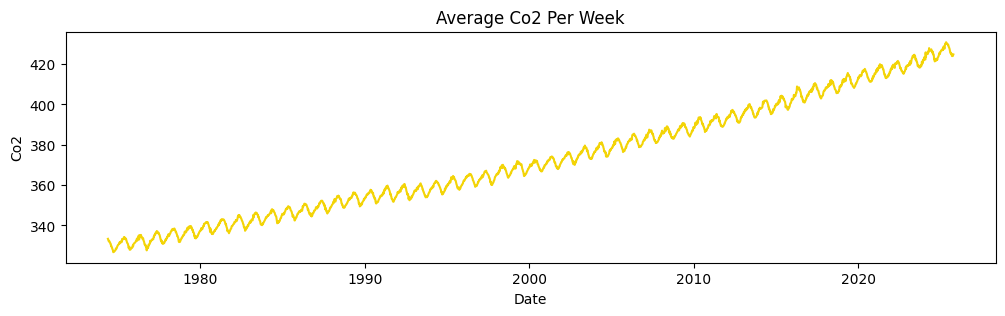

In [27]:
plot_base(co2['average'], 'Average Co2 Per Week', 'Date', 'Co2')

In [28]:
result = adfuller(co2['average'])
print(f'p-value = {result[1]:.5f}')

p-value = 0.98798


In this graphic we have static variance, but our p-value = 0.98798
so our series is non-stationary.


In [29]:
y_seasonal = co2['average'].diff(52).dropna()
result = adfuller(y_seasonal)
print(f"ADF seasonal diff p-value = {result[1]:.5f}")

y_seasonal_first = y_seasonal.diff().dropna()
result = adfuller(y_seasonal_first)
print(f"ADF seasonal+first diff p-value = {result[1]:.5f}")

ADF seasonal diff p-value = 0.00008
ADF seasonal+first diff p-value = 0.00000


### 2 Manual Model Selection

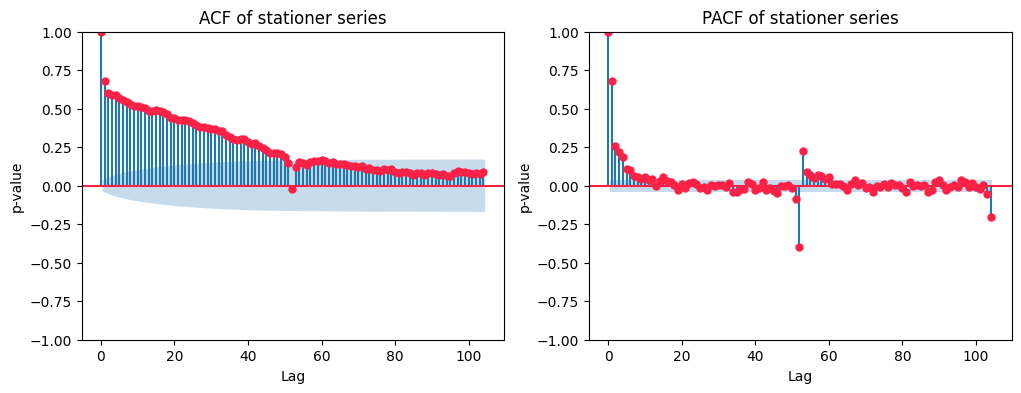

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(y_seasonal, lags=104, ax=axes[0], color='#FD2146')
axes[0].set_title('ACF of stationer series')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('p-value')

plot_pacf(y_seasonal, lags=104, ax=axes[1], color='#FD2146')
axes[1].set_title('PACF of stationer series')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p-value')

plt.show()

### 3 Estimation and AutoARIM

In [31]:
train = co2.loc[co2.index < '2015-07-05']
val = co2.loc[co2.index >= '2015-07-05']

In [32]:
train = train[['average']].reset_index()
train['unique_id'] = 'co2'
train.rename(columns={'data_ind': 'ds', 'average': 'y'}, inplace=True)
train = train[['unique_id', 'ds', 'y']]

val = val[['average']].reset_index()
val['unique_id'] = 'co2'
val.rename(columns={'data_ind': 'ds', 'average': 'y'}, inplace=True)
val = val[['unique_id', 'ds', 'y']]

,unique_id,ds,y
0,co2,2015-07-05,401.90
1,co2,2015-07-12,401.57
2,co2,2015-07-19,401.43
3,co2,2015-07-26,400.38
4,co2,2015-08-02,398.54


ARIMA(order=(p=0, d=1, q=1), seasonal_order=(P=1, D=1, Q=1))

m=52

In [33]:
models = [
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1), season_length=52, alias="arima012011"),
  ARIMA(order=(2, 1, 0), seasonal_order=(0, 1, 1), season_length=52, alias="arima210011"),
  AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=52),
]

sf = StatsForecast(models=models, freq="W", n_jobs=-1)
sf.fit(df=train)
summaries = []

for model in sf.fitted_[0]:
  summary_model = {
    "model": model,
    "Orders": ARIMASummary(model.model_),
    "sigma2": model.model_["sigma2"],
    "loglik": model.model_["loglik"],
    "aic": model.model_["aic"],
    "aicc": model.model_["aicc"],
    "bic": model.model_["bic"],
  }
  summaries.append(summary_model)

pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))

,model,Orders,sigma2,loglik,aic,aicc,bic
0,arima012011,"ARIMA(0,1,2)(0,1,1)[52]",0.186925,-1223.409922,2454.819843,2454.839001,2477.405258
1,arima210011,"ARIMA(2,1,0)(0,1,1)[52]",0.198009,-1293.585307,2595.170614,2595.189771,2617.756029
2,auto,"ARIMA(0,1,3)(2,1,0)[52]",0.211147,-1340.198968,2692.397936,2692.438204,2726.276058


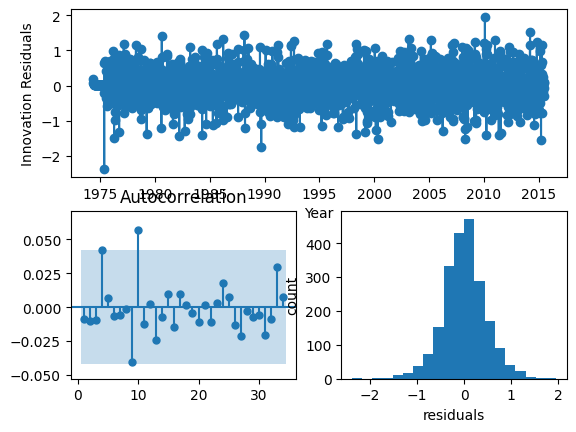

In [34]:
forecasts = sf.forecast(
  df=train[["ds", "y", "unique_id"]], h=len(val['y']), fitted=True, level=[80, 95]
)
fitted_values = sf.forecast_fitted_values()
insample_forecasts = fitted_values["auto"]
residuals = fitted_values["y"] - insample_forecasts

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax1.plot(train["ds"], residuals, marker="o")
ax1.set_ylabel("Innovation Residuals")
ax1.set_xlabel("Year")
plot_acf(
  residuals, ax2, zero=False,
  bartlett_confint=False, auto_ylims=True
)
ax3.hist(residuals, bins=20)
ax3.set_ylabel("count")
ax3.set_xlabel("residuals")
plt.show()

In [35]:
ljung_box = acorr_ljungbox(residuals, lags=[52], model_df=4)
ljung_box

,lb_stat,lb_pvalue
52,61.555475,0.090467


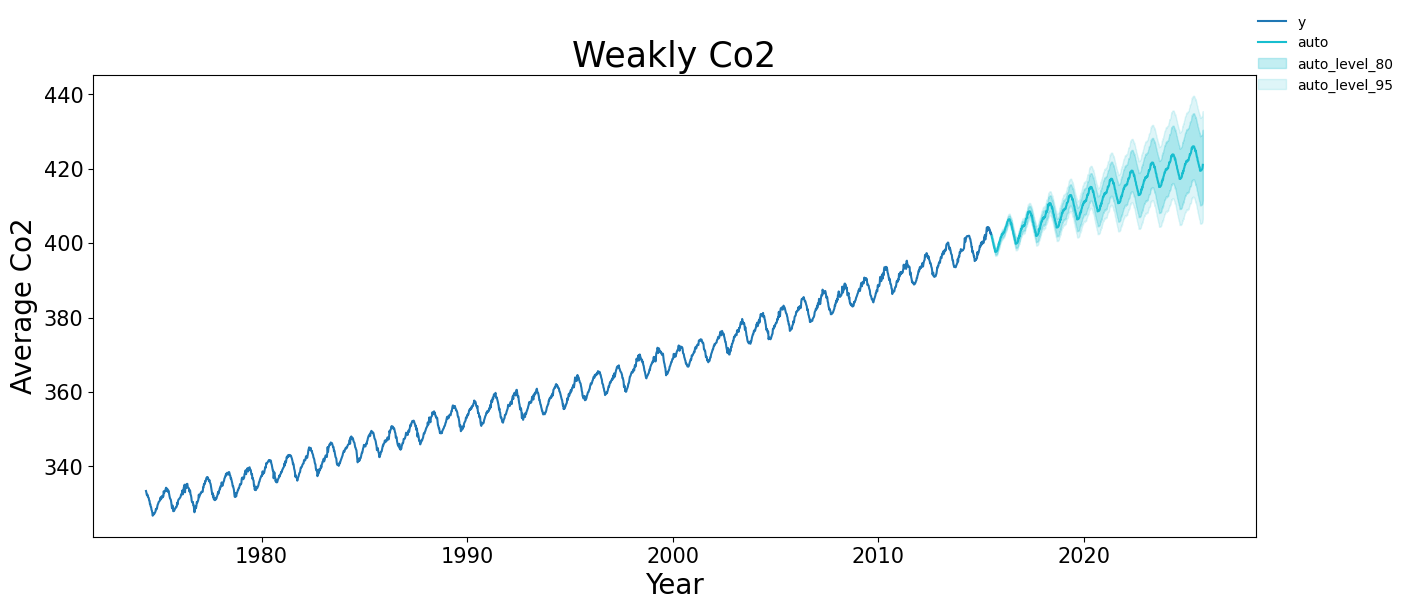

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_series(
  df=train,
  forecasts_df=forecasts.reset_index()[
    [
      "unique_id", "ds", "auto",
      "auto-lo-80", "auto-lo-95",
      "auto-hi-80", "auto-hi-95",
    ]
  ],
  level=[80, 95], rm_legend=False,
  xlabel="Year", ylabel="Average Co2",
  title="Weakly Co2", ax=ax,
)

ax.axvline(pd.to_datetime("2015-07-05"), color="black", ls="--")
plt.show()

### 4 ARIMA vs ETS

In [37]:
train["y"] /= 1e6

models = [AutoARIMA(), AutoETS()]
sf = StatsForecast(models=models, freq="W", n_jobs=-1)
cv_forecasts = sf.cross_validation(h=1, n_windows=10, df=train)
error_metrics = [rmse, mae, smape]
errors = pd.DataFrame()
for error_metric in error_metrics:
  error = error_metric(cv_forecasts.reset_index(),
    models=["AutoARIMA", "AutoETS"])
  error.rename(index={0: error_metric.__name__}, inplace=True)
  errors = pd.concat((errors, error))
errors.drop(columns="unique_id").T

,rmse,mae,smape
AutoARIMA,4.772615e-07,3.846746e-07,0.000477
AutoETS,4.111435e-07,3.392382e-07,0.000420


---
## Hourly AEP

In [38]:
aep = pd.read_csv('../data/hourly_aep.csv')
aep['data_ind'] = aep['Date']
aep = aep.set_index('data_ind')
aep.index = pd.to_datetime(aep.index)

### 1 Stationarity and Differencing


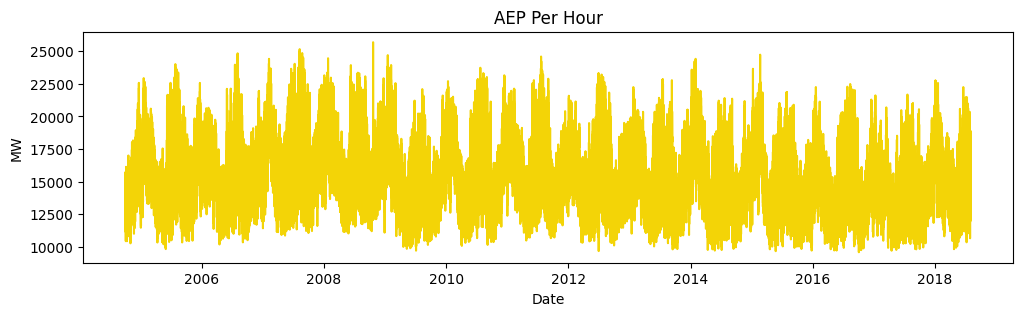

In [39]:
plot_base(aep['AEP_MW'], 'AEP Per Hour', 'Date', 'MW')

In [40]:
result = adfuller(aep['AEP_MW'])
print(f'p-value = {result[1]:.5f}')

p-value = 0.00000


In this graphic we have static variance, our p-value = 0.00000 so our series is stationary.
So we don't need any transformation.

In [41]:
y_seasonal = aep['AEP_MW'].diff(24).dropna() # year
result = adfuller(y_seasonal)
print(f"ADF seasonal diff p-value = {result[1]:.5f}")

y_seasonal_first = y_seasonal.diff().dropna()
result = adfuller(y_seasonal_first)
print(f"ADF seasonal+first diff p-value = {result[1]:.5f}")

ADF seasonal diff p-value = 0.00000
ADF seasonal+first diff p-value = 0.00000


### 2 Manual Model Selection

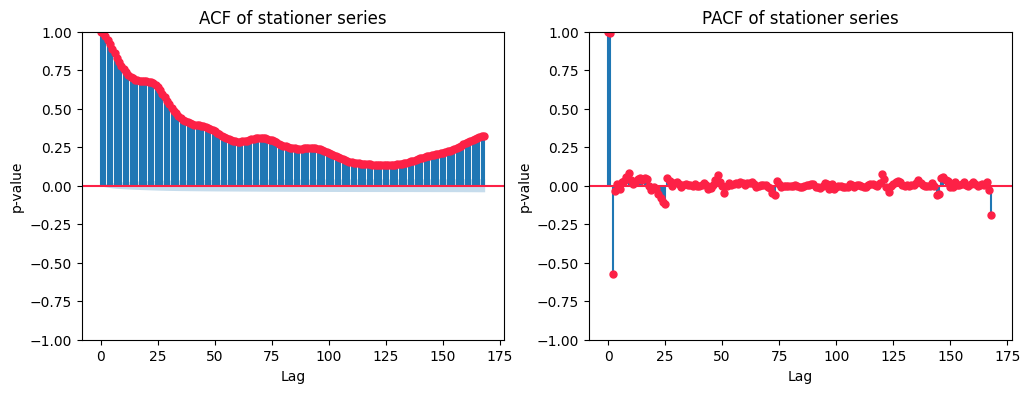

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(y_seasonal, lags=24*7, ax=axes[0], color='#FD2146')
axes[0].set_title('ACF of stationer series')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('p-value')

plot_pacf(y_seasonal, lags=24*7, ax=axes[1], color='#FD2146') # 12*2*31 (month) / 2
axes[1].set_title('PACF of stationer series')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('p-value')

plt.show()

### 3 Estimation and AutoARIM

In [43]:
train = aep.loc[aep.index < '2015-10-27 06:00:00']
val = aep.loc[aep.index >= '2015-10-27 06:00:00']

In [44]:
train = train[['AEP_MW']].reset_index()
train['unique_id'] = 'mw'
train.rename(columns={'data_ind': 'ds', 'AEP_MW': 'y'}, inplace=True)
train = train[['unique_id', 'ds', 'y']]

val = val[['AEP_MW']].reset_index()
val['unique_id'] = 'mw'
val.rename(columns={'data_ind': 'ds', 'AEP_MW': 'y'}, inplace=True)
val = val[['unique_id', 'ds', 'y']]

,unique_id,ds,y
0,mw,2015-10-27 06:00:00,12583.0
1,mw,2015-10-27 07:00:00,14032.0
2,mw,2015-10-27 08:00:00,14867.0
3,mw,2015-10-27 09:00:00,14837.0
4,mw,2015-10-27 10:00:00,15147.0


In [46]:
models = [
  ARIMA(order=(0, 1, 2), seasonal_order=(2, 1, 2), season_length=24, alias="arima012212"),
  ARIMA(order=(2, 1, 0), seasonal_order=(1, 3, 15), season_length=24, alias="arima2101315"),
  AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=24),
]

sf = StatsForecast(models=models, freq="h", n_jobs=-1)
sf.fit(df=train)
summaries = []

for model in sf.fitted_[0]:
  summary_model = {
    "model": model,
    "Orders": ARIMASummary(model.model_),
    "sigma2": model.model_["sigma2"],
    "loglik": model.model_["loglik"],
    "aic": model.model_["aic"],
    "aicc": model.model_["aicc"],
    "bic": model.model_["bic"],
  }
  summaries.append(summary_model)

pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))

KeyboardInterrupt: 

In [ ]:
forecasts = sf.forecast(
  df=train[["ds", "y", "unique_id"]], h=len(val['y']), fitted=True, level=[80, 95]
)
fitted_values = sf.forecast_fitted_values()
insample_forecasts = fitted_values["auto"]
residuals = fitted_values["y"] - insample_forecasts

fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax1.plot(train["ds"], residuals, marker="o")
ax1.set_ylabel("Innovation Residuals")
ax1.set_xlabel("Year")
plot_acf(
  residuals, ax2, zero=False,
  bartlett_confint=False, auto_ylims=True
)
ax3.hist(residuals, bins=20)
ax3.set_ylabel("count")
ax3.set_xlabel("residuals")
plt.show()

In [ ]:
ljung_box = acorr_ljungbox(residuals, lags=[24], model_df=4)
ljung_box

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_series(
  df=train,
  forecasts_df=forecasts.reset_index()[
    [
      "unique_id", "ds", "auto",
      "auto-lo-80", "auto-lo-95",
      "auto-hi-80", "auto-hi-95",
    ]
  ],
  level=[80, 95], rm_legend=False,
  xlabel="Year", ylabel="AEP MW",
  title="Hourly AEP", ax=ax
)

ax.axvline(pd.to_datetime("2015-10-27 06:00:00"), color="black", ls="--")
plt.show()

### 4 ARIMA vs ETS

In [ ]:
train["y"] /= 1e6

models = [AutoARIMA(), AutoETS()]
sf = StatsForecast(models=models, freq="h", n_jobs=-1)
cv_forecasts = sf.cross_validation(h=1, n_windows=10, df=train)
error_metrics = [rmse, mae, smape]
errors = pd.DataFrame()
for error_metric in error_metrics:
  error = error_metric(cv_forecasts.reset_index(),
    models=["AutoARIMA", "AutoETS"])
  error.rename(index={0: error_metric.__name__}, inplace=True)
  errors = pd.concat((errors, error))
errors.drop(columns="unique_id").T

---

Для всіх трьох часових рядів ARIMA і ETS справляються майже однаково
для `tempt_df` ETS трохи виграє, а більшості `co2_df` та `aep_df` важко сказати хто кращею